In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# box-cox transformation for skeewed data
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data transformation functions

# find best boxcox transformation. Include datetime index if given
def boxcox_transform(x,lmda=None,alpha=None,optimizer=None):
    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.Series(data=boxcox_data, index=index, name=name)
            
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    else:
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)
            return boxcox_data

# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    reversed_data = inv_boxcox(x, lmda, out=None)

    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name

        reversed_data = pd.DataFrame(reversed_data, index=index, columns=[name])

        return reversed_data

    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        
        return reversed_data
        
    else:
        return reversed_data


import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed_W1.csv")

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# make list with dma names
dma_list = list(inflow_data.columns.values)

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed_W1.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

# drop uncorrelated features
#weather_data = weather_data.drop(['Rainfall depth (mm)','Air humidity (%)','Windspeed (km/h)'], axis=1)

In [3]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

In [4]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-07-11'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

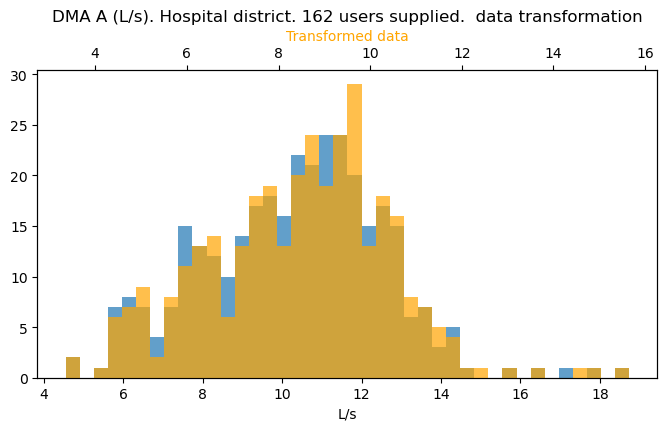

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11077D+00    |proj g|=  3.04994D+00


 This problem is unconstrained.



At iterate    5    f=  1.74655D+00    |proj g|=  2.76805D-01

At iterate   10    f=  1.61900D+00    |proj g|=  1.13975D-01

At iterate   15    f=  1.59558D+00    |proj g|=  5.87670D-02

At iterate   20    f=  1.59181D+00    |proj g|=  1.10163D-02

At iterate   25    f=  1.59164D+00    |proj g|=  5.32628D-03

At iterate   30    f=  1.59161D+00    |proj g|=  4.25247D-03

At iterate   35    f=  1.59151D+00    |proj g|=  7.50540D-03

At iterate   40    f=  1.59141D+00    |proj g|=  9.65986D-03

At iterate   45    f=  1.59132D+00    |proj g|=  6.70728D-03

At iterate   50    f=  1.58908D+00    |proj g|=  7.75882D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

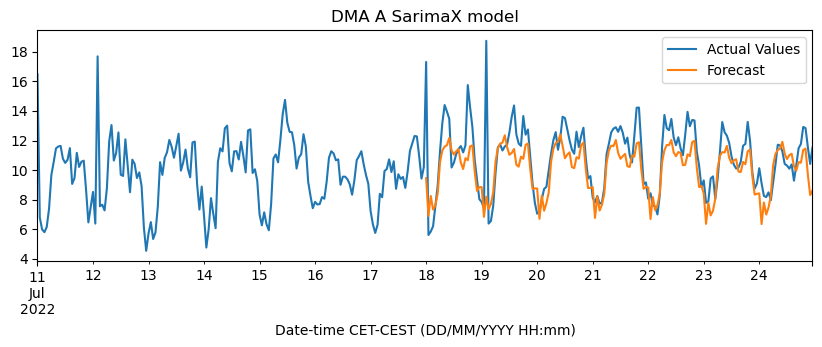

Performance indicators
DMA A SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.61            7.84             1.11           10.56 

Performance indicators


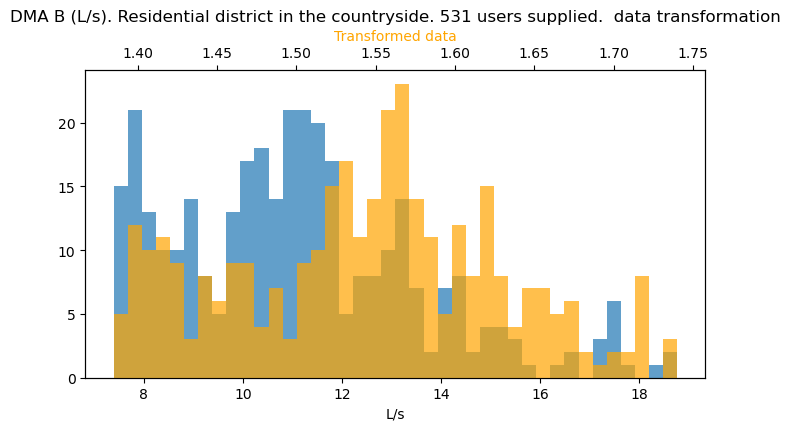

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91510D+00    |proj g|=  1.41186D+01


 This problem is unconstrained.



At iterate    5    f= -1.92650D+00    |proj g|=  2.92192D+01

At iterate   10    f= -1.93263D+00    |proj g|=  6.58354D-01

At iterate   15    f= -1.93367D+00    |proj g|=  1.43461D+01

At iterate   20    f= -1.95999D+00    |proj g|=  4.39956D+01

At iterate   25    f= -1.97823D+00    |proj g|=  1.69730D+01

At iterate   30    f= -1.99325D+00    |proj g|=  6.60335D+00

At iterate   35    f= -2.06744D+00    |proj g|=  8.14591D+00

At iterate   40    f= -2.10254D+00    |proj g|=  1.10862D+00

At iterate   45    f= -2.10305D+00    |proj g|=  1.25824D+00

At iterate   50    f= -2.12156D+00    |proj g|=  5.23800D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

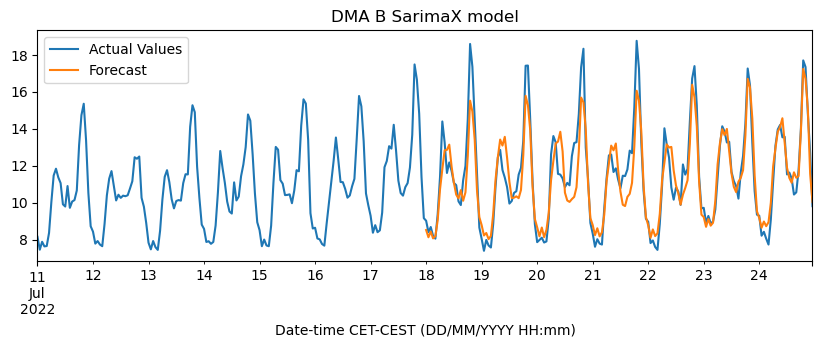

Performance indicators
DMA B SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.91            3.07             0.78           4.76 

Performance indicators


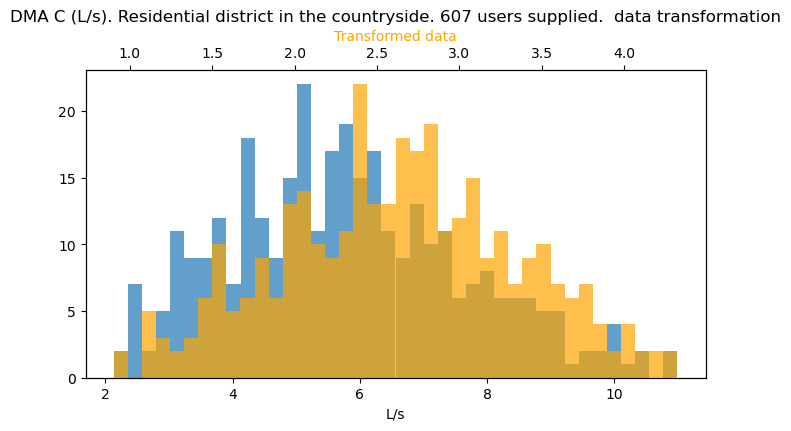

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02329D-01    |proj g|=  4.26086D+00


 This problem is unconstrained.



At iterate    5    f=  8.37647D-02    |proj g|=  2.86729D+00

At iterate   10    f= -9.16040D-02    |proj g|=  3.08722D+00

At iterate   15    f= -1.05111D-01    |proj g|=  3.59117D-01

At iterate   20    f= -1.23817D-01    |proj g|=  8.93865D-01

At iterate   25    f= -1.25304D-01    |proj g|=  3.99002D-01

At iterate   30    f= -1.37992D-01    |proj g|=  1.39910D+00

At iterate   35    f= -1.40933D-01    |proj g|=  5.80255D-01

At iterate   40    f= -1.50120D-01    |proj g|=  7.43477D-01

At iterate   45    f= -1.54538D-01    |proj g|=  5.05746D-01

At iterate   50    f= -1.57336D-01    |proj g|=  4.71104D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

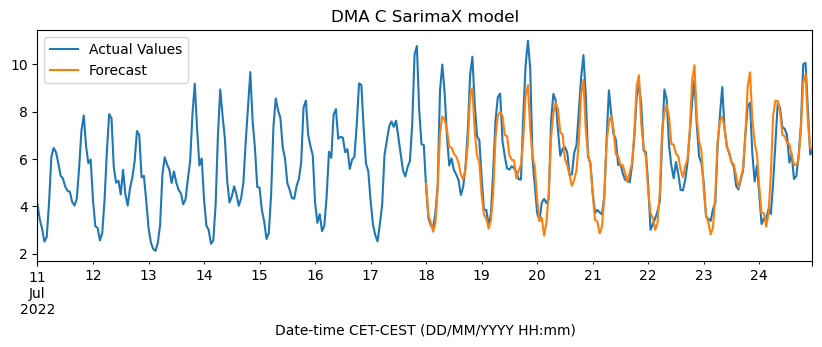

Performance indicators
DMA C SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.70            2.19             0.57           3.46 

Performance indicators


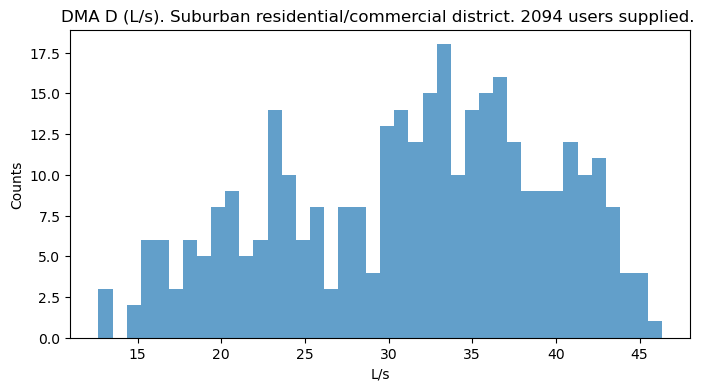

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44038D+00    |proj g|=  4.60370D-01


 This problem is unconstrained.



At iterate    5    f=  2.22695D+00    |proj g|=  1.95953D-01

At iterate   10    f=  2.19111D+00    |proj g|=  1.15712D-01

At iterate   15    f=  2.18780D+00    |proj g|=  9.43003D-03

At iterate   20    f=  2.18641D+00    |proj g|=  8.00277D-03

At iterate   25    f=  2.18480D+00    |proj g|=  8.24882D-02

At iterate   30    f=  2.18387D+00    |proj g|=  6.55609D-03

At iterate   35    f=  2.18383D+00    |proj g|=  3.64464D-03

At iterate   40    f=  2.18377D+00    |proj g|=  8.40274D-03

At iterate   45    f=  2.18368D+00    |proj g|=  1.27472D-02

At iterate   50    f=  2.18361D+00    |proj g|=  3.55728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

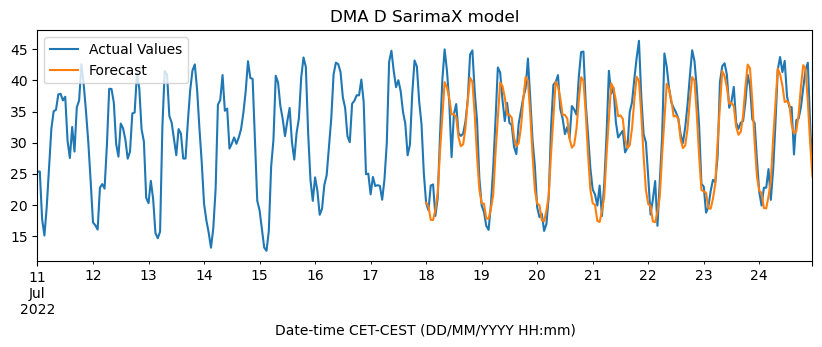

Performance indicators
DMA D SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.70            6.85             2.60           12.15 



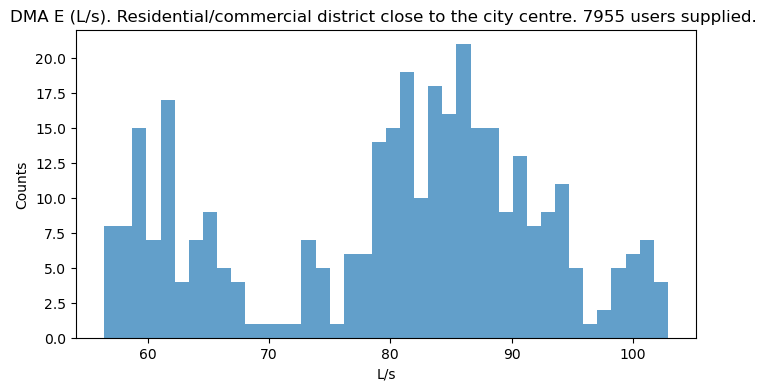

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21486D+00    |proj g|=  7.93750D-01


 This problem is unconstrained.



At iterate    5    f=  1.87881D+00    |proj g|=  8.31111D-01

At iterate   10    f=  1.77368D+00    |proj g|=  1.13459D-01

At iterate   15    f=  1.76206D+00    |proj g|=  7.89374D-02

At iterate   20    f=  1.75896D+00    |proj g|=  2.44964D-02

At iterate   25    f=  1.75687D+00    |proj g|=  1.40198D-02

At iterate   30    f=  1.75588D+00    |proj g|=  3.53458D-02

At iterate   35    f=  1.75513D+00    |proj g|=  4.14116D-02

At iterate   40    f=  1.75465D+00    |proj g|=  3.18506D-02

At iterate   45    f=  1.75412D+00    |proj g|=  8.64521D-03

At iterate   50    f=  1.75372D+00    |proj g|=  2.93087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

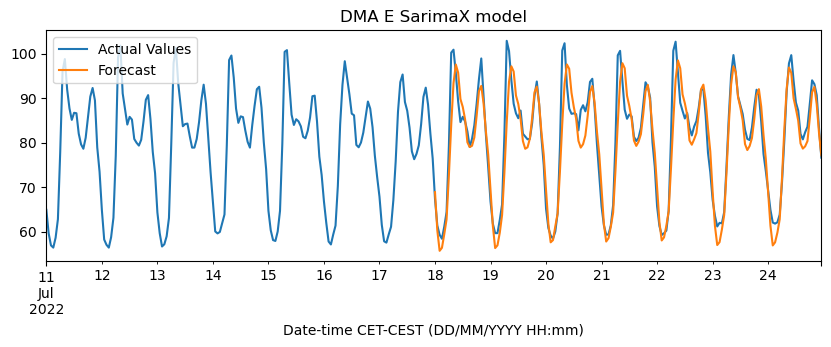

Performance indicators
DMA E SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.41            16.31             3.07           22.79 



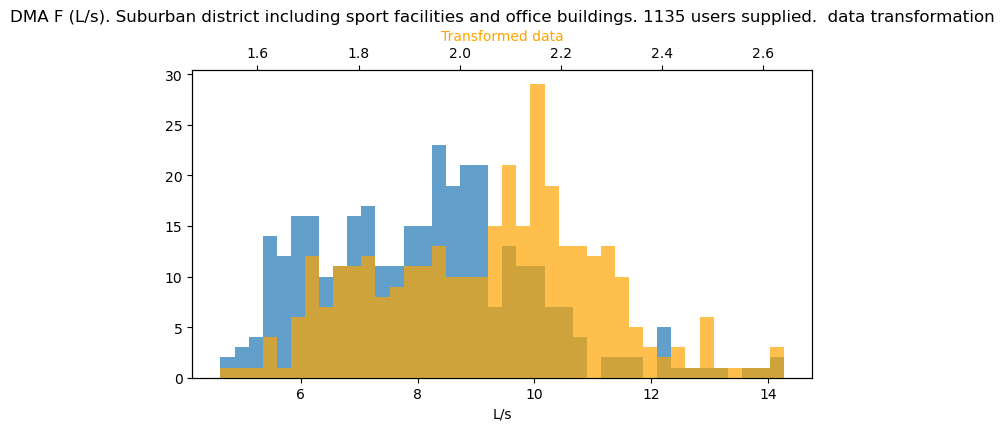

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.48071D-01    |proj g|=  4.63008D+00


 This problem is unconstrained.



At iterate    5    f= -3.96492D-01    |proj g|=  6.96252D-01

At iterate   10    f= -3.99191D-01    |proj g|=  1.47386D-01

At iterate   15    f= -4.08585D-01    |proj g|=  4.50884D+00

At iterate   20    f= -4.16660D-01    |proj g|=  9.49484D-02

At iterate   25    f= -4.18119D-01    |proj g|=  3.07598D+00

At iterate   30    f= -4.27022D-01    |proj g|=  6.22445D-01

At iterate   35    f= -4.27545D-01    |proj g|=  2.24807D-01

At iterate   40    f= -4.34004D-01    |proj g|=  1.62048D+00

At iterate   45    f= -4.37181D-01    |proj g|=  1.09499D-01

At iterate   50    f= -4.37478D-01    |proj g|=  3.42001D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

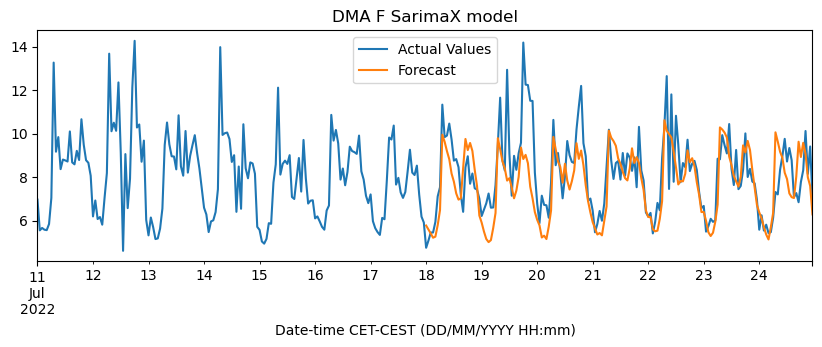

Performance indicators
DMA F SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.95            2.02             1.04           4.01 

Performance indicators


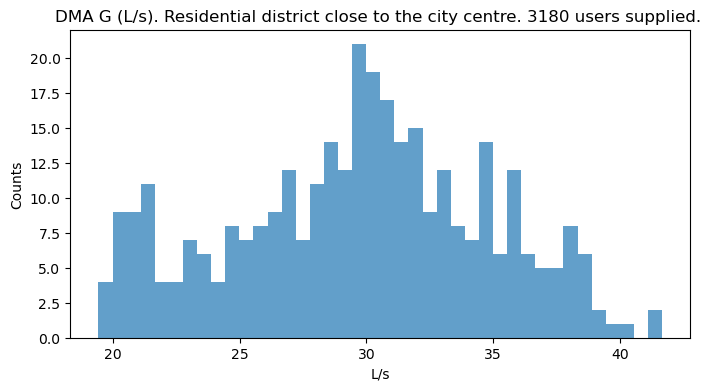

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45883D+00    |proj g|=  3.40918D-01


 This problem is unconstrained.



At iterate    5    f=  1.43486D+00    |proj g|=  5.81500D-02

At iterate   10    f=  1.42979D+00    |proj g|=  1.31416D-02

At iterate   15    f=  1.42776D+00    |proj g|=  2.86766D-02

At iterate   20    f=  1.42564D+00    |proj g|=  4.16823D-02

At iterate   25    f=  1.42487D+00    |proj g|=  1.76618D-02

At iterate   30    f=  1.42329D+00    |proj g|=  1.11804D-02

At iterate   35    f=  1.42290D+00    |proj g|=  1.28081D-02

At iterate   40    f=  1.42245D+00    |proj g|=  3.59939D-02

At iterate   45    f=  1.42110D+00    |proj g|=  1.92466D-02

At iterate   50    f=  1.42028D+00    |proj g|=  2.55410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

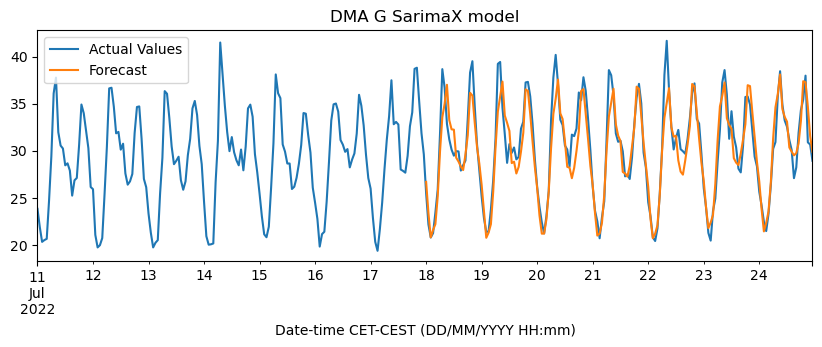

Performance indicators
DMA G SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.59            5.09             1.39           8.07 



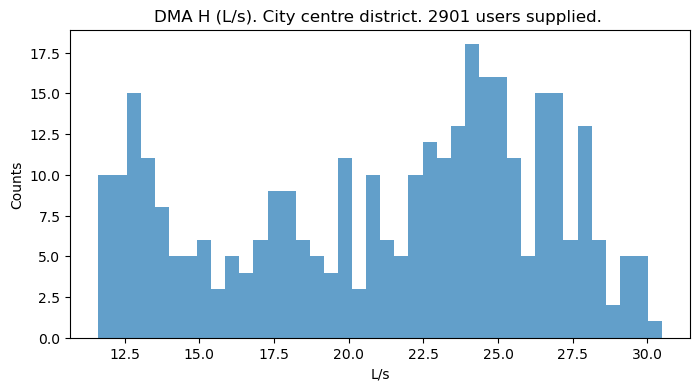

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66564D+00    |proj g|=  4.51359D-01


 This problem is unconstrained.



At iterate    5    f=  1.62002D+00    |proj g|=  2.92667D-02

At iterate   10    f=  1.61885D+00    |proj g|=  2.00585D-02

At iterate   15    f=  1.61874D+00    |proj g|=  2.51539D-02

At iterate   20    f=  1.61759D+00    |proj g|=  3.07757D-02

At iterate   25    f=  1.61551D+00    |proj g|=  4.84164D-02

At iterate   30    f=  1.61371D+00    |proj g|=  2.95378D-02

At iterate   35    f=  1.61264D+00    |proj g|=  8.50686D-02

At iterate   40    f=  1.61048D+00    |proj g|=  3.93001D-02

At iterate   45    f=  1.60956D+00    |proj g|=  8.72683D-02

At iterate   50    f=  1.60869D+00    |proj g|=  2.53619D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

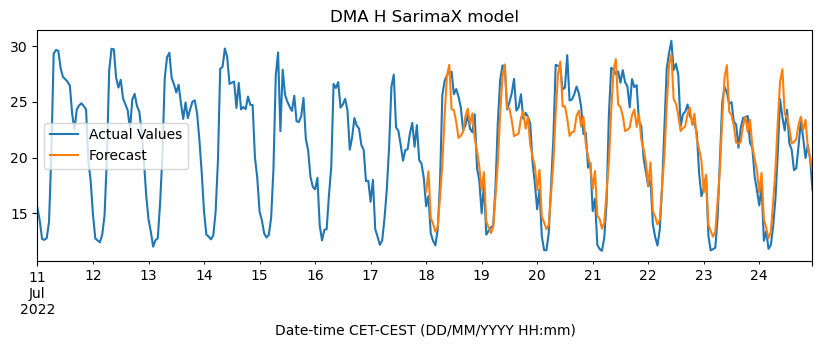

Performance indicators
DMA H SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.75            6.26             1.66           9.67 



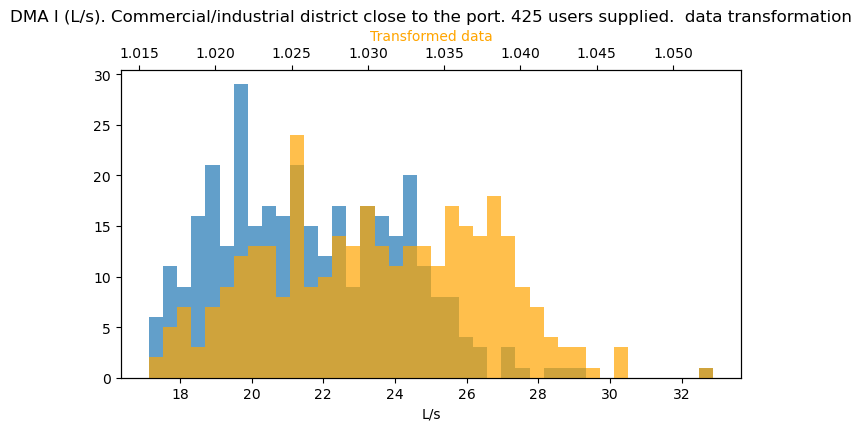

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.54001D+00    |proj g|=  2.73696D+01


 This problem is unconstrained.



At iterate    5    f= -3.54117D+00    |proj g|=  6.36524D+01

At iterate   10    f= -3.54309D+00    |proj g|=  2.43535D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     14     37      1     0     0   7.715D+00  -3.543D+00
  F =  -3.5432017310885779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


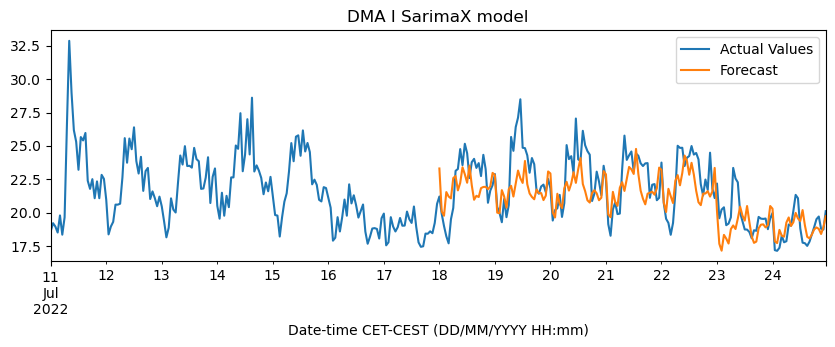

Performance indicators
DMA I SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.67            3.51             1.37           6.54 

Performance indicators


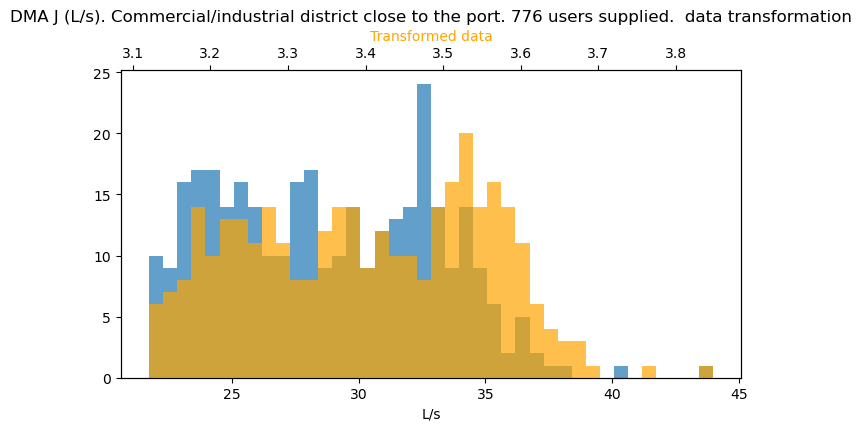

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25340D+00    |proj g|=  1.83213D+00


 This problem is unconstrained.



At iterate    5    f= -1.25367D+00    |proj g|=  1.25845D+00

At iterate   10    f= -1.25385D+00    |proj g|=  1.21864D+00

At iterate   15    f= -1.25503D+00    |proj g|=  3.28918D+00

At iterate   20    f= -1.25780D+00    |proj g|=  7.10380D+00

At iterate   25    f= -1.26287D+00    |proj g|=  4.90765D-01

At iterate   30    f= -1.26423D+00    |proj g|=  5.13619D+00

At iterate   35    f= -1.27535D+00    |proj g|=  6.21542D+00

At iterate   40    f= -1.28160D+00    |proj g|=  1.15840D+00

At iterate   45    f= -1.28502D+00    |proj g|=  9.43964D-01

At iterate   50    f= -1.28787D+00    |proj g|=  4.31064D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

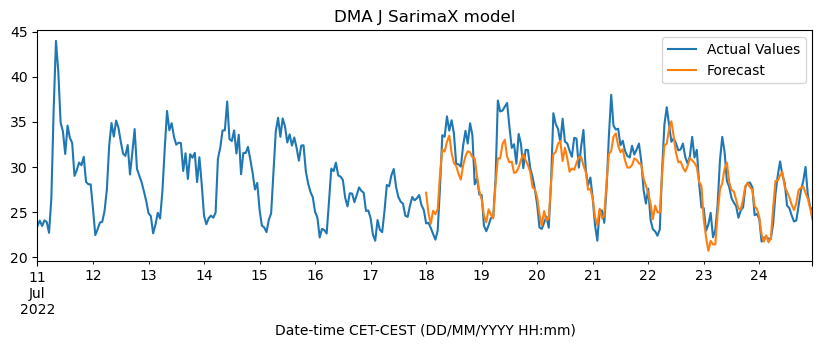

Performance indicators
DMA J SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.89            3.61             1.48           6.99 

Performance indicators


In [5]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

i = 0
# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    ## data transformation
    if dma not in ['DMA D (L/s)','DMA E (L/s)','DMA G (L/s)','DMA H (L/s)']:
        inflow_data_transformed, lmda = boxcox_transform(tseries_df,lmda=None,alpha=None,optimizer=None)

        # compare distributions of original and transformed data
        fig, ax = plt.subplots(figsize=(8,4))
        ax2 = ax.twiny()
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. " + " data transformation")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        ax2.hist(inflow_data_transformed.values, density=False,bins=40, color='orange', alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        ax2.set_xlabel("Transformed data", color='orange')
        plt.show()


        # demand time series
        y = inflow_data_transformed
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        y_train_original, y_test_original = temporal_train_test_split(tseries_df, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.

        model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        # make predictions
        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        # recover prediction in original format
        y_pred_recovered = inv_boxcox_tranform(y_pred['mean'], lmda, out=None)
        y_pred_recovered_lower = inv_boxcox_tranform(y_pred['mean_ci_lower'], lmda, out=None)
        y_pred_recovered_upper = inv_boxcox_tranform(y_pred['mean_ci_upper'], lmda, out=None)

        # plot results
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # # plot forecast and last two weeks of time series
        # fig, ax = plt.subplots(figsize = (10,3))
        # tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        # y_pred_recovered.plot(y='mean',ax = ax)
        # #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        # ax.legend(['Actual Values', 'Forecast'])
        # plt.show()

        print('Performance indicators')
        df = print_metrics(y_test_original, y_pred_recovered, dma[:5]+' SarimaX 1-Week',return_df=1)
        results_df = pd.concat([results_df, df])
        print('Performance indicators')
    else:
        # plot data distribution
        fig, ax = plt.subplots(figsize=(8,4))
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. ")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        plt.show()

        # demand time series
        y = tseries_df
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)


        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.
        model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 1-Week',return_df=1)
        results_df = pd.concat([results_df, df])
    i = i+1

In [6]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 1-Week,1.606,7.842,1.115,10.564
DMA B SarimaX 1-Week,0.908,3.074,0.782,4.764
DMA C SarimaX 1-Week,0.704,2.193,0.566,3.462
DMA D SarimaX 1-Week,2.702,6.852,2.599,12.153
DMA E SarimaX 1-Week,3.407,16.306,3.073,22.786
DMA F SarimaX 1-Week,0.953,2.019,1.037,4.009
DMA G SarimaX 1-Week,1.586,5.094,1.388,8.068
DMA H SarimaX 1-Week,1.746,6.259,1.660,9.666
DMA I SarimaX 1-Week,1.670,3.507,1.366,6.544
DMA J SarimaX 1-Week,1.891,3.613,1.482,6.985


In [7]:
results_df['Total'].sum()

89.001